# Imports

In [ ]:
import time
import os
import math
from copy import deepcopy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


# Data Prep

In [11]:
df_bond = pd.read_parquet("bond_data.parquet")
df_bond = df_bond.iloc[:, 1:]
df_bond = df_bond.dropna()
df_bond = df_bond[(df_bond['corp_yield'] < 1.0) & (df_bond['corp_yield'] > 0)]
df_bond['obs_date'] = pd.to_datetime(df_bond['obs_date'])

df_bond['months_since_2000'] = (
    (df_bond['obs_date'].dt.year - 2000) * 12 + df_bond['obs_date'].dt.month
)
df_bond['month'] = df_bond['obs_date'].dt.month
df_bond['sin_month'] = np.sin(2 * np.pi * df_bond['month'] / 12)
df_bond['cos_month'] = np.cos(2 * np.pi * df_bond['month'] / 12)

# Binning for group lags since CUSIP level lags are not feasable
coupon_bins = [0, 2, 4, 6, 8, 10, float('inf')]
maturity_bins = [0, 1, 3, 5, 10, float('inf')]
df_bond['coupon_bin'] = pd.cut(df_bond['coupon'], bins=coupon_bins, labels=False)
df_bond['maturity_bin'] = pd.cut(df_bond['time_to_maturity'], bins=maturity_bins, labels=False)
df_bond = df_bond.sort_values(by=['rating_num', 'coupon_bin', 'maturity_bin', 'obs_date'])
df_bond['group_avg_yield'] = df_bond.groupby(
    ['obs_date', 'rating_num', 'coupon_bin', 'maturity_bin']
)['corp_yield'].transform('mean')
df_bond['group_avg_yield_lag1'] = df_bond.groupby(
    ['rating_num', 'coupon_bin', 'maturity_bin']
)['group_avg_yield'].shift(1)
df_bond = df_bond.dropna(subset=['group_avg_yield_lag1'])
df_bond['group_avg_yield_lag1'] = (
    df_bond.groupby('rating_class')['group_avg_yield'].shift(1)
)
df_bond = df_bond.dropna(subset=['group_avg_yield_lag1'])
features = [
    'time_to_maturity', 'coupon', 'rating_num',
    't_volume', 't_spread', 'duration',
    'months_since_2000', 'sin_month', 'cos_month',
    'group_avg_yield_lag1'
]

df_bond


,obs_date,cusip,time_to_maturity,coupon,rating_num,rating_class,t_volume,t_spread,corp_yield,corp_price,amount_outstanding,duration,months_since_2000,month,sin_month,cos_month,coupon_bin,maturity_bin,group_avg_yield,group_avg_yield_lag1
10480,2013-02-28,594918AF1,0.586111,0.875,1.0,0.IG,3.275100e+07,0.000429,0.002572,100.357670,1000000.0,0.571067,158,2,0.866025,5.000000e-01,0.0,0,0.002572,0.001825
16731,2013-03-31,594918AF1,0.500000,0.875,1.0,0.IG,1.246910e+08,0.000335,0.003132,100.273000,1000000.0,0.492380,159,3,1.000000,6.123234e-17,0.0,0,0.003132,0.002572
23011,2013-04-30,594918AF1,0.416667,0.875,1.0,0.IG,4.013400e+07,0.000319,0.002815,100.239966,1000000.0,0.410381,160,4,0.866025,-5.000000e-01,0.0,0,0.002815,0.003132
29311,2013-05-31,594918AF1,0.330556,0.875,1.0,0.IG,5.943500e+07,0.000543,0.003844,100.156000,1000000.0,0.325402,161,5,0.500000,-8.660254e-01,0.0,0,0.003372,0.002815
29866,2013-05-31,478160AX2,0.969444,1.200,1.0,0.IG,2.422010e+08,0.000445,0.002901,100.866969,1000000.0,0.955919,161,5,0.500000,-8.660254e-01,0.0,0,0.003372,0.003372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86229,2014-02-28,254709AE8,5.452778,10.250,10.0,0.IG,3.940000e+05,0.018167,0.043754,127.901600,78484.0,4.274145,170,2,0.866025,5.000000e-01,5.0,3,0.039644,0.039644
92749,2014-03-31,254709AE8,5.366667,10.250,10.0,0.IG,1.668000e+06,0.018378,0.042505,128.187500,78484.0,4.196676,171,3,1.000000,6.123234e-17,5.0,3,0.042505,0.039644
118943,2014-07-31,254709AE8,5.027778,10.250,10.0,0.IG,6.940000e+05,0.010497,0.035194,130.344629,78484.0,4.060061,175,7,-0.500000,-8.660254e-01,5.0,3,0.035194,0.042505
433360,2018-01-31,958102AL9,6.255556,10.500,10.0,0.IG,1.056118e+09,0.001538,0.070690,116.901231,3332119.0,4.517133,217,1,0.500000,8.660254e-01,5.0,3,0.070690,0.035194


## Train/Val/Test & Tensor Setup

In [12]:
# ----- Setup -----
device = torch.device("cpu")

features = [
    'time_to_maturity', 'coupon', 'rating_num', 't_volume', 't_spread', 'duration',
    'months_since_2000', 'sin_month', 'cos_month',
    'coupon_bin', 'maturity_bin', 'group_avg_yield_lag1'
]
target = 'corp_yield'

df_bond['obs_date'] = pd.to_datetime(df_bond['obs_date'])
df_bond = df_bond.sort_values('obs_date')

# ----- Time-based Split -----
test_date = pd.Timestamp('2024-03-31')
df_test = df_bond[df_bond['obs_date'] == test_date].dropna(subset=features + [target])
df_model = df_bond[df_bond['obs_date'] < test_date].dropna(subset=features + [target])

n_total = len(df_model)
n_train = int(n_total * 0.8)
df_train = df_model.iloc[:n_train]
df_val   = df_model.iloc[n_train:]

# ----- Scaling -----
scaler_X = StandardScaler().fit(df_train[features])
scaler_y = StandardScaler().fit(df_train[[target]])

X_train = scaler_X.transform(df_train[features].astype(np.float32))
y_train = scaler_y.transform(df_train[[target]].astype(np.float32))
X_val   = scaler_X.transform(df_val[features].astype(np.float32))
y_val   = scaler_y.transform(df_val[[target]].astype(np.float32))
X_test  = scaler_X.transform(df_test[features].astype(np.float32))
y_test  = scaler_y.transform(df_test[[target]].astype(np.float32))

# ----- Tensors -----
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Models

Efficient KAN implementation copied from https://github.com/Blealtan/efficient-kan/blob/master/src/efficient_kan/kan.py <br>
This stripped down version was used for simplicity of implementation but lacks the primary features of the KAN model, the symbolic output. <br>
However since this project just focuses on the optimizer and training, this was chosen.

In [13]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

Custom SPSA and 2SPSA implementation to work with KAN. 2SPSA has an issue with memory and is not stable.

In [14]:
def flatten_params(params):
    return torch.cat([p.data.view(-1) for p in params])

def unflatten_params(model, flat_tensor):
    idx = 0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        shape = p.data.shape
        numel = p.data.numel()
        p.data.copy_(flat_tensor[idx:idx+numel].view(shape))
        idx += numel

def spsa_gradient(model, loss_fn, X, y, c):
    theta = flatten_params(model.parameters())
    delta = torch.randint(0, 2, theta.shape, dtype=torch.float32) * 2 - 1

    theta_plus = theta + c * delta
    theta_minus = theta - c * delta

    model_plus = deepcopy(model)
    model_minus = deepcopy(model)

    model_plus.eval()
    model_minus.eval()

    unflatten_params(model_plus, theta_plus)
    unflatten_params(model_minus, theta_minus)

    with torch.no_grad():
        loss_plus = loss_fn(model_plus(X), y) + model_plus.regularization_loss() # + lambda_reg <- Need to add here for future testing
        loss_minus = loss_fn(model_minus(X), y) + model_minus.regularization_loss() # + lambda_reg

    grad_est = (loss_plus - loss_minus) / (2 * c) * delta
    return grad_est

def spsa_update(model, grad_est, a):
    theta = flatten_params(model.parameters())
    theta_new = theta - a * grad_est
    unflatten_params(model, theta_new)

def two_spsa_hessian(model, loss_fn, X, y, c):
    theta = flatten_params(model.parameters())
    delta = torch.randint(0, 2, theta.shape, dtype=torch.float32) * 2 - 1

    theta_plus = theta + c * delta
    theta_minus = theta - c * delta

    model_plus = deepcopy(model)
    model_minus = deepcopy(model)

    model_plus.eval()
    model_minus.eval()

    unflatten_params(model_plus, theta_plus)
    unflatten_params(model_minus, theta_minus)

    with torch.no_grad():
        grad_plus = torch.autograd.grad(
            loss_fn(model_plus(X), y) + model_plus.regularization_loss(),
            inputs=list(model_plus.parameters()), retain_graph=False, create_graph=False
        )
        grad_minus = torch.autograd.grad(
            loss_fn(model_minus(X), y) + model_minus.regularization_loss(),
            inputs=list(model_minus.parameters()), retain_graph=False, create_graph=False
        )

    grad_plus_flat = torch.cat([g.view(-1) for g in grad_plus])
    grad_minus_flat = torch.cat([g.view(-1) for g in grad_minus])

    hessian_diag_est = (grad_plus_flat - grad_minus_flat) / (2 * c * delta)
    return hessian_diag_est

def two_spsa_update(model, grad_est, hess_diag, a):
    theta = flatten_params(model.parameters())
    theta_new = theta - a * grad_est / (hess_diag.abs() + 1e-6)
    unflatten_params(model, theta_new)


# Tests

In [15]:
# ----- Backup Files (if training fails) -----

LOG_FILE = 'kan_optimizer_log.csv'
LOG_FILE2 = 'kan_optimizer_log.csv'

# ----- Config -----
MAX_EPOCHS = 50
LAMBDA_REG = 1.0  # regularization strength

# ----- Optimizer Zoo -----
optimizer_configs = {
    'SGD': lambda params: torch.optim.SGD(params, lr=1e-2),
    'Adam': lambda params: torch.optim.Adam(params, lr=1e-3),
    'LBFGS': lambda params: torch.optim.LBFGS(params, lr=1.0, max_iter=4, history_size=10),
    'SPSA': lambda params: None,
    'AdamW': lambda params: torch.optim.AdamW(params, lr=1e-3),
    'RMSprop': lambda params: torch.optim.RMSprop(params, lr=1e-3),
    'Adagrad': lambda params: torch.optim.Adagrad(params, lr=1e-2),
    # '2SPSA': lambda params: None
}

# ----- Log DF for Model and Optimizer Results -----
log_columns = [
    'optimizer', 'epoch', 'iteration', 'train_loss', 'val_loss', 'test_loss',
    'reg_loss', 'total_loss', 'time_elapsed_sec', 'gradient_norm', 'step_size'
]
logs = []


In [ ]:
# ----- Training -----
try:
    for opt_name, opt_fn in optimizer_configs.items():
        print(f"\n==== Starting optimizer: {opt_name} ====")
        model = KAN([X_train_tensor.shape[1], 32, 1]).to(X_train_tensor.device)

        if opt_name in ['SPSA', '2SPSA']:
            optimizer = None
        else:
            optimizer = opt_fn(model.parameters())

        loss_fn = nn.MSELoss()
        iteration = 0
        start_time = time.time()

        for epoch in range(1, MAX_EPOCHS + 1):
            print(f"Optimizer: {opt_name} | Epoch {epoch}")
            model.train()

            if opt_name == 'LBFGS':
                def closure():
                    optimizer.zero_grad()
                    y_pred = model(X_train_tensor)
                    loss = loss_fn(y_pred, y_train_tensor)
                    reg_loss = model.regularization_loss()
                    total_loss = loss + LAMBDA_REG * reg_loss
                    total_loss.backward()
                    return total_loss
                optimizer.step(closure)
                y_pred = model(X_train_tensor)
                loss = loss_fn(y_pred, y_train_tensor)

            elif opt_name in ['SPSA', '2SPSA']:
                # SPSA hyperparameter schedule
                a = 0.01 / (epoch ** 0.602)
                c = 0.1 / (epoch ** 0.101)

                grad_est = spsa_gradient(model, loss_fn, X_train_tensor, y_train_tensor, c)

                if opt_name == '2SPSA':
                    hess_diag = two_spsa_hessian(model, loss_fn, X_train_tensor, y_train_tensor, c)
                    two_spsa_update(model, grad_est, hess_diag, a)
                else:
                    spsa_update(model, grad_est, a)

                y_pred = model(X_train_tensor)
                loss = loss_fn(y_pred, y_train_tensor)

            else:  # Adam, SGD
                optimizer.zero_grad()
                y_pred = model(X_train_tensor)
                loss = loss_fn(y_pred, y_train_tensor)
                reg_loss = model.regularization_loss()
                total_loss = loss + LAMBDA_REG * reg_loss
                total_loss.backward()
                optimizer.step()

            # Manual gradient norm for SPSA
            grad_norm = 0.0
            if opt_name in ['SPSA', '2SPSA']:
                grad_norm = grad_est.norm().item()
            else:
                for param in model.parameters():
                    if param.grad is not None:
                        grad_norm += param.grad.data.norm(2).item() ** 2
                grad_norm = grad_norm ** 0.5

            model.eval()
            with torch.no_grad():
                val_loss = loss_fn(model(X_val_tensor), y_val_tensor).item()
                test_loss = loss_fn(model(X_test_tensor), y_test_tensor).item()
                reg_loss = model.regularization_loss().item()
                train_loss = loss.item()
                total_loss = train_loss + LAMBDA_REG * reg_loss
                elapsed = time.time() - start_time

                step_size = a if opt_name in ['SPSA', '2SPSA'] else next(iter(optimizer.param_groups))['lr']

                logs.append({
                    'optimizer': opt_name,
                    'epoch': epoch,
                    'iteration': iteration,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'test_loss': test_loss,
                    'reg_loss': reg_loss,
                    'total_loss': total_loss,
                    'time_elapsed_sec': elapsed,
                    'gradient_norm': grad_norm,
                    'step_size': step_size
                })
                pd.DataFrame([logs[-1]]).to_csv(LOG_FILE, index=False, mode='a', header=not os.path.exists(LOG_FILE))

            iteration += 1
except KeyboardInterrupt:
    print("Training interrupted. Saving log...")
    pd.DataFrame(logs).to_csv(LOG_FILE2, index=False, mode='a')

log_df = pd.DataFrame(logs)



==== Starting optimizer: SGD ====
Optimizer: SGD | Epoch 1
Optimizer: SGD | Epoch 2
Optimizer: SGD | Epoch 3
Optimizer: SGD | Epoch 4
Optimizer: SGD | Epoch 5
Optimizer: SGD | Epoch 6
Optimizer: SGD | Epoch 7
Optimizer: SGD | Epoch 8
Optimizer: SGD | Epoch 9
Optimizer: SGD | Epoch 10
Optimizer: SGD | Epoch 11
Optimizer: SGD | Epoch 12
Optimizer: SGD | Epoch 13
Optimizer: SGD | Epoch 14
Optimizer: SGD | Epoch 15
Optimizer: SGD | Epoch 16
Optimizer: SGD | Epoch 17
Optimizer: SGD | Epoch 18
Optimizer: SGD | Epoch 19
Optimizer: SGD | Epoch 20
Optimizer: SGD | Epoch 21
Optimizer: SGD | Epoch 22
Optimizer: SGD | Epoch 23
Optimizer: SGD | Epoch 24
Optimizer: SGD | Epoch 25
Optimizer: SGD | Epoch 26
Optimizer: SGD | Epoch 27
Optimizer: SGD | Epoch 28
Optimizer: SGD | Epoch 29
Optimizer: SGD | Epoch 30
Optimizer: SGD | Epoch 31
Optimizer: SGD | Epoch 32
Optimizer: SGD | Epoch 33
Optimizer: SGD | Epoch 34
Optimizer: SGD | Epoch 35
Optimizer: SGD | Epoch 36
Optimizer: SGD | Epoch 37
Optimizer: S

In [9]:
log_df = pd.read_csv(LOG_FILE)
log_df

,optimizer,epoch,iteration,train_loss,val_loss,test_loss,reg_loss,total_loss,time_elapsed_sec,gradient_norm,step_size
0,SGD,1,0,0.9028441905975342,2.8393332958221436,3.426823139190674,11.67477798461914,12.577622175216675,7.5157082080841064,8.398535777460818,0.01
1,optimizer,epoch,iteration,train_loss,val_loss,test_loss,reg_loss,total_loss,time_elapsed_sec,gradient_norm,step_size
2,SGD,1,0,0.9028441905975342,2.8393332958221436,3.426823139190674,11.67477798461914,12.577622175216675,7.5157082080841064,8.398535777460818,0.01
3,SGD,2,1,0.8954648971557617,2.8279333114624023,3.420233726501465,11.249163627624512,12.144628524780273,14.611432552337646,10.01172281258884,0.01
4,optimizer,epoch,iteration,train_loss,val_loss,test_loss,reg_loss,total_loss,time_elapsed_sec,gradient_norm,step_size
...,...,...,...,...,...,...,...,...,...,...,...
61888,Adagrad,46,45,0.4885786175727844,2.420825958251953,3.247853994369507,8.534402847290039,9.022981464862823,372.94954085350037,31.515908698695092,0.01
61889,Adagrad,47,46,0.48694419860839844,2.409284830093384,3.232090950012207,8.495781898498535,8.982726097106934,380.7980718612671,30.00885623724071,0.01
61890,Adagrad,48,47,0.48498961329460144,2.3983678817749023,3.218636989593506,8.377520561218262,8.862510174512863,388.7501561641693,30.221434955396383,0.01
61891,Adagrad,49,48,0.48327457904815674,2.3861265182495117,3.2020747661590576,8.340781211853027,8.824055790901184,396.7450475692749,32.47254775847252,0.01


Checking for L-BFGS results, stuck in local minima or saddle point and then expldoes and resets?

In [7]:
log_df[log_df['optimizer']=='LBFGS']

,optimizer,epoch,iteration,train_loss,val_loss,test_loss,reg_loss,total_loss,time_elapsed_sec,gradient_norm,step_size
18,LBFGS,1,0,0.9289348721504211,2.707608222961426,3.3569915294647217,10.25247859954834,11.181413471698761,30.403626441955566,10.911556320548947,1.0
24,LBFGS,1,0,0.9289348721504211,2.707608222961426,3.3569915294647217,10.25247859954834,11.181413471698761,30.403626441955566,10.911556320548947,1.0
25,LBFGS,2,1,0.9196946024894714,2.6951897144317627,3.3463497161865234,9.281210899353027,10.200905501842499,59.177828788757324,13.145282527646241,1.0
31,LBFGS,1,0,0.9289348721504211,2.707608222961426,3.3569915294647217,10.25247859954834,11.181413471698761,30.403626441955566,10.911556320548947,1.0
32,LBFGS,2,1,0.9196946024894714,2.6951897144317627,3.3463497161865234,9.281210899353027,10.200905501842499,59.177828788757324,13.145282527646241,1.0
...,...,...,...,...,...,...,...,...,...,...,...
61688,LBFGS,46,45,0.413433313369751,1.4815223217010498,2.0781259536743164,10.78760814666748,11.201041460037231,1402.5925023555756,10.8343995691996,1.0
61689,LBFGS,47,46,0.40413784980773926,1.5106903314590454,2.111623525619507,15.28573226928711,15.689870119094849,1434.0559413433075,13.231424595293433,1.0
61690,LBFGS,48,47,0.40022701025009155,1.5349587202072144,2.1462562084198,9.722829818725586,10.123056828975677,1464.039748430252,13.981393158153425,1.0
61691,LBFGS,49,48,0.4003424644470215,1.53225576877594,2.1417415142059326,8.800459861755371,9.200802326202393,1495.4263548851013,26.2032176727984,1.0


Remove outliers for plotting

In [32]:
log_df = log_df[~((log_df["optimizer"] == "LBFGS") & (log_df["train_loss"] > 1))].copy()


## By Epoch

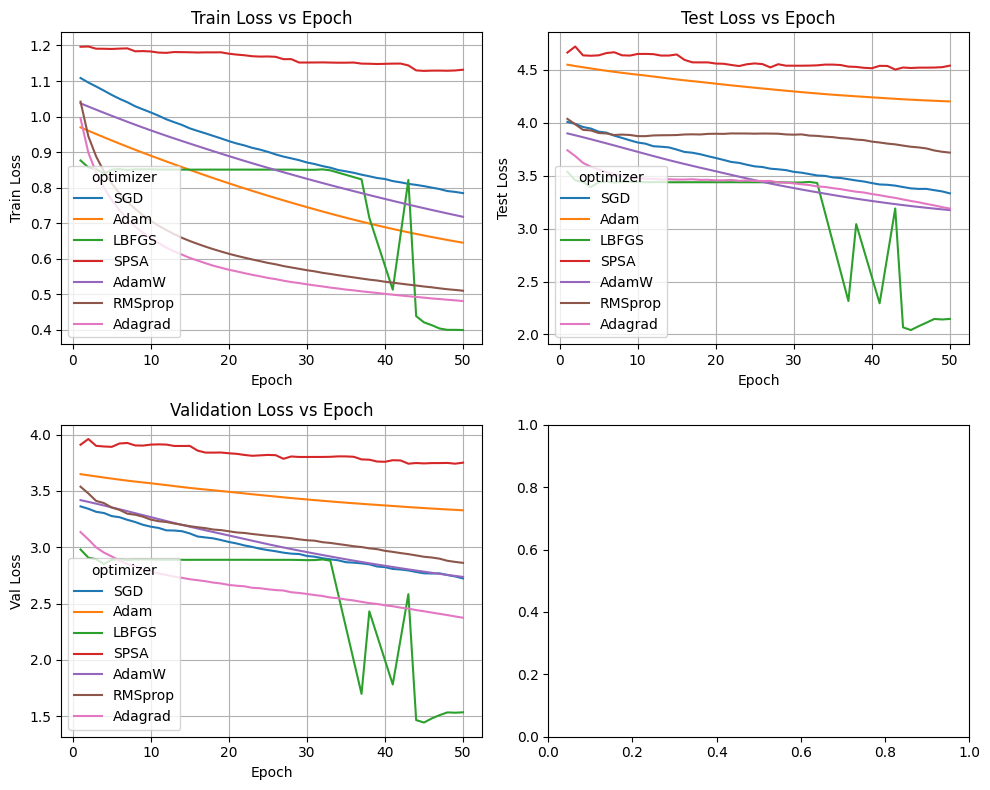

In [ ]:
log_df['time_elapsed_sec_norm'] = (
    log_df.groupby('optimizer')['time_elapsed_sec'].transform(lambda x: x - x.min())
)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Train Loss
sns.lineplot(data=log_df, x='epoch', y='train_loss', hue='optimizer', ax=axes[0,0])
axes[0,0].set_title("Train Loss vs Epoch")
axes[0,0].set_xlabel("Epoch")
axes[0,0].set_ylabel("Train Loss")
axes[0,0].grid(True)

# Validation Loss
sns.lineplot(data=log_df, x='epoch', y='val_loss', hue='optimizer', ax=axes[1,0])
axes[1,0].set_title("Validation Loss vs Epoch")
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Val Loss")
axes[1,0].grid(True)

# Test Loss
sns.lineplot(data=log_df, x='epoch', y='test_loss', hue='optimizer', ax=axes[0,1])
axes[0,1].set_title("Test Loss vs Epoch")
axes[0,1].set_xlabel("Epoch")
axes[0,1].set_ylabel("Test Loss")
axes[0,1].grid(True)

plt.tight_layout()
plt.show()


## By Time

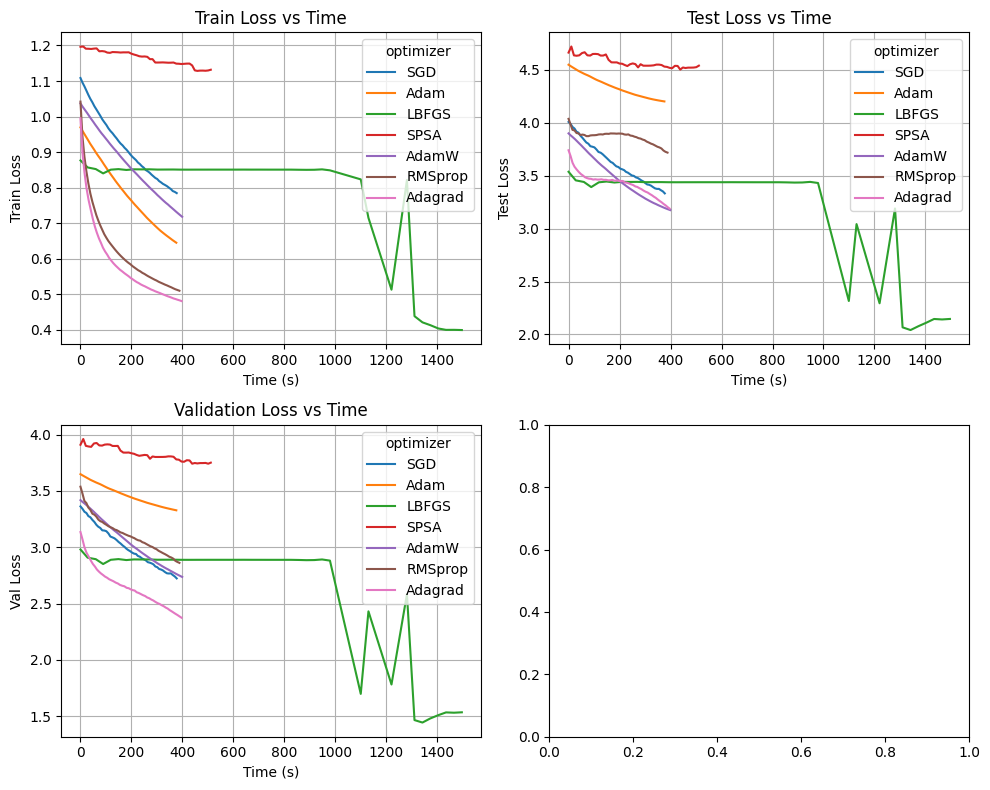

In [ ]:
log_df['time_elapsed_sec_norm'] = (
    log_df.groupby('optimizer')['time_elapsed_sec'].transform(lambda x: x - x.min())
)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.lineplot(data=log_df, x='time_elapsed_sec_norm', y='train_loss', hue='optimizer', ax=axes[0,0])
axes[0,0].set_title("Train Loss vs Time")
axes[0,0].set_xlabel("Time (s)")
axes[0,0].set_ylabel("Train Loss")
axes[0,0].grid(True)

sns.lineplot(data=log_df, x='time_elapsed_sec_norm', y='val_loss', hue='optimizer', ax=axes[1,0])
axes[1,0].set_title("Validation Loss vs Time")
axes[1,0].set_xlabel("Time (s)")
axes[1,0].set_ylabel("Val Loss")
axes[1,0].grid(True)

sns.lineplot(data=log_df, x='time_elapsed_sec_norm', y='test_loss', hue='optimizer', ax=axes[0,1])
axes[0,1].set_title("Test Loss vs Time")
axes[0,1].set_xlabel("Time (s)")
axes[0,1].set_ylabel("Test Loss")
axes[0,1].grid(True)

plt.tight_layout()
plt.show()


## Other

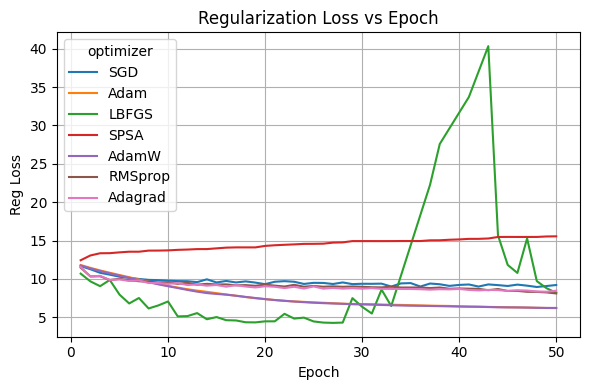

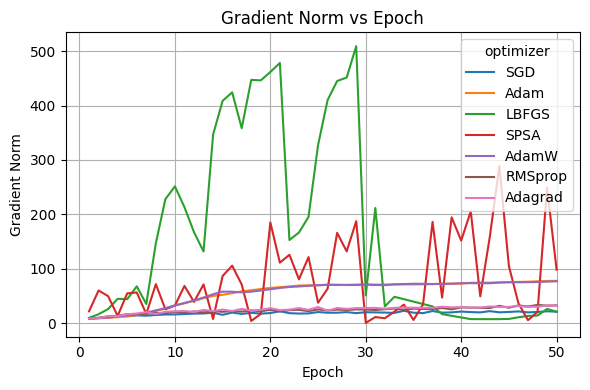

In [ ]:
# Regularization Loss vs Epoch

plt.figure(figsize=(6, 4))
sns.lineplot(data=log_df, x='epoch', y='reg_loss', hue='optimizer')
plt.title("Regularization Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Reg Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gradient Norm vs Epoch
plt.figure(figsize=(6, 4))
sns.lineplot(data=log_df, x='epoch', y='gradient_norm', hue='optimizer')
plt.title("Gradient Norm vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
summary_df = (
    log_df.sort_values('epoch')
          .groupby('optimizer')
          .tail(1)  # last epoch per optimizer
          .reset_index(drop=True)
          .loc[:, ['optimizer', 'epoch', 'train_loss', 'val_loss', 'test_loss', 'reg_loss', 'total_loss', 'time_elapsed_sec', 'gradient_norm', 'step_size']]
          .sort_values('val_loss')  # optionally sort by val_loss
)

print(summary_df.to_string(index=False))


optimizer  epoch  train_loss  val_loss  test_loss  reg_loss  total_loss  time_elapsed_sec  gradient_norm  step_size
    LBFGS     50    0.399736  1.535890   2.146587  8.202077    8.601813       1526.224927      20.836565   1.000000
  Adagrad     50    0.481271  2.374968   3.188250  8.469053    8.950324        404.368885      32.740973   0.010000
      SGD     50    0.784796  2.723699   3.331859  9.215892   10.000688        385.893145      21.164017   0.010000
    AdamW     50    0.718205  2.736666   3.174150  6.230543    6.948748        407.326925      76.978125   0.001000
  RMSprop     50    0.510308  2.861578   3.716709  8.115170    8.625477        396.844308      32.595749   0.001000
     Adam     50    0.645325  3.327867   4.199892  6.208672    6.853996        383.586611      77.761245   0.001000
     SPSA     50    1.131764  3.750531   4.537559 15.559985   16.691750        522.260986      98.222183   0.000949
